# Project
## Team: The Optimizers

# Training Model

### Import libraries


In [37]:
#import libraries

import numpy as np
import cv2

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow import keras

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50

from time import time

import warnings
warnings.filterwarnings('ignore')

### Modify Data Path and File Name


In [2]:
basepath = "./"
training_data_filename = 'data_train.npy'
training_target_filename = 't_train.npy'

#### Load the Data

In [3]:
# Loading Data

X = np.load(basepath+training_data_filename).T
t = np.load(basepath+training_target_filename)

print('Number of Samples: ', X.shape[0])

Number of Samples:  9032


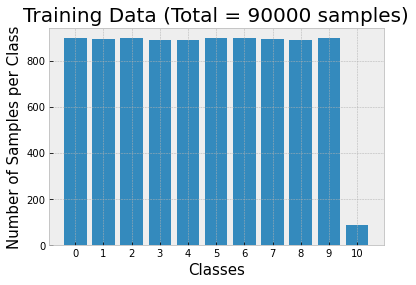

In [4]:
# Counting number samples per class
vals, counts = np.unique(t, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(11),range(11))
plt.xlabel('Classes',size=15)
plt.ylabel('Number of Samples per Class', size=15)
plt.title('Training Data (Total = '+str(X.shape[1])+' samples)',size=20);

In [5]:
# Labels Integer Encoding
labels_names = ['x','square root','plus sign','negative sign',
                'equal','percent','partial','product','pi','summation','unkn. own']

___

### Train the Model

In [6]:
def preprocess_data (X, D):
    '''
    This function preprocesses the input data
    Input Data is converted to RGB color model to be used with ResNet
    Input Data is reshaped in required format of the input layer of Neural Network
    '''
    
    #converting to rgb from greyscale 
    X_rgb = np.array([ cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in X])
    
    #Reshaping Data
    X_rs = tf.constant(X_rgb.reshape((X_rgb.shape[0],D,D, 3)), dtype=tf.float32)
    
    return X_rs

In [7]:
def plot_learning_curve(n_epochs, history):
    '''
    This function plots the learing curve
    '''

    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(n_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [8]:
def train_model (X, t):
    
    '''
    This function trains the handwritten mathematical symbols dataset
    using Transfer learning and classification
    '''

    #image dimension
    D = 200
    
    #model training parameters
    epochs = 50  
    patience = 10     
    batch_size = 32
    
    #Downscaling image for dimension reduction
    X_rescaled = np.array([ cv2.resize(x.reshape(300,300),(D,D)).reshape(D*D) for x in X ])

    ## Split Data into Training, Validation Set and Test Set
    
    #Split the data for training and testing
    X_train_data, X_test, t_train_data, t_test = train_test_split(X_rescaled, t,
                                                    shuffle=True, stratify=t,
                                                    test_size=0.15)
    
    #saving for testing
    np.save('X_test.npy', X_test)
    np.save('t_test.npy', t_test)


    #Split the data for training and validation
    X_train, X_val, t_train, t_val = train_test_split(X_train_data, t_train_data,
                                                    shuffle=True, stratify=t_train_data,
                                                    test_size=0.2)


    print("\nTraining Data Dimension: ", X_train.shape)
    print("Training Labels Dimension: ", t_train.shape)

    print("\nValidation Data Dimension: ", X_val.shape)
    print("Validation Labels Dimension: ", t_val.shape)

    print("\nTest Data Dimension: ", X_test.shape)
    print("Test Labels Dimension: ", t_test.shape)
    
    
    #Pre-process the data of each set
    
    X_train_rs = preprocess_data (X_train, D)
    print("\nReshaped Training Data: ", X_train_rs.shape)
    
    X_val_rs = preprocess_data (X_val, D)
    print("\nReshaped Validation Data: ", X_val_rs.shape)

    #X_test_rs = preprocess_data (X_test, D)
    #print("\nReshaped Test Data: ", X_test_rs.shape)
    
    
    ###Build the training model
    
    ##Transfer learning using ResNet
    #allow custom input and output layers
    #use weights of trained imagenet dataset
    base_model = ResNet50(input_shape=(D,D,3),
                                include_top=False,
                                weights="imagenet")

    # Some weights in later layers are unfreezed, rest are Freezed
    for layer in base_model.layers[:-5]:
        layer.trainable=False
        
    #print(len(base_model.layers))
    #base_model.summary()
    num_classes = len(labels_names)
    
    #building top layers including output layer for classification
    tf.random.set_seed(21)

    model = tf.keras.models.Sequential([
        
        #use pre-trained base model
        base_model,
        
        #classification layers
        GlobalAveragePooling2D(),    

        Dense(512,  kernel_initializer='lecun_normal', use_bias = False), 
        keras.layers.BatchNormalization(),
        keras.layers.Activation('selu'),
        Dropout(0.7),
    
        Dense(256,  kernel_initializer='lecun_normal', use_bias = False), 
        keras.layers.BatchNormalization(),
        keras.layers.Activation('selu'),
        Dropout(0.5),

        keras.layers.Dense(128,  kernel_initializer='lecun_normal', use_bias = False), 
        keras.layers.BatchNormalization(),
        keras.layers.Activation('selu'),
        Dropout(0.3),

        keras.layers.Dense(32,  kernel_initializer='lecun_normal', use_bias = False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('selu'),
        Dropout(0.2),

        #output layer
        Dense(num_classes, activation='softmax')
    ])
    
    
    #define loss function and optimizer
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer=keras.optimizers.Adam(learning_rate=0.01, beta_1 = 0.9, beta_2 = 0.999)
    
    #compile the model
    model.compile(loss=loss,optimizer=optimizer, metrics=['accuracy'])
    

    #early-stopping
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    #training - fit the model
    history = model.fit(X_train_rs, t_train,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val_rs,t_val),
                        callbacks=[callback])
    
    n_epochs = len(history.history['loss'])
    print("\nTraining completed in ", n_epochs, "epochs")
    print('The Accuracy on Validation Dataset is: %.2f%%'%(np.max(history.history['val_accuracy'])*100))

    #Plot the learning curve
    plot_learning_curve(n_epochs, history.history)
    
    #save the model
    #model.save('the_optimizers_classification_model.h5')
    
    return model
    


### Run the Training Model


Training Data Dimension:  (6141, 40000)
Training Labels Dimension:  (6141,)

Validation Data Dimension:  (1536, 40000)
Validation Labels Dimension:  (1536,)

Test Data Dimension:  (1355, 40000)
Test Labels Dimension:  (1355,)


2022-12-07 19:10:14.692341: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 19:10:15.176079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0



Reshaped Training Data:  (6141, 200, 200, 3)

Reshaped Validation Data:  (1536, 200, 200, 3)
Epoch 1/50


2022-12-07 19:10:21.274329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-12-07 19:10:22.148361: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-12-07 19:10:22.253075: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-07 19:10:23.071912: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


192/192 [==============================] - 21s 93ms/step - loss: 1.0138 - accuracy: 0.6649 - val_loss: 0.5893 - val_accuracy: 0.8242
Epoch 2/50
192/192 [==============================] - 17s 90ms/step - loss: 0.6012 - accuracy: 0.8013 - val_loss: 0.4470 - val_accuracy: 0.8704
Epoch 3/50
192/192 [==============================] - 17s 90ms/step - loss: 0.4368 - accuracy: 0.8582 - val_loss: 0.5404 - val_accuracy: 0.8424
Epoch 4/50
192/192 [==============================] - 17s 90ms/step - loss: 0.3848 - accuracy: 0.8769 - val_loss: 0.4122 - val_accuracy: 0.8770
Epoch 5/50
192/192 [==============================] - 17s 90ms/step - loss: 0.3318 - accuracy: 0.8901 - val_loss: 0.3567 - val_accuracy: 0.8880
Epoch 6/50
192/192 [==============================] - 17s 90ms/step - loss: 0.2847 - accuracy: 0.9082 - val_loss: 0.3738 - val_accuracy: 0.8926
Epoch 7/50
192/192 [==============================] - 17s 89ms/step - loss: 0.2419 - accuracy: 0.9220 - val_loss: 0.3795 - val_accuracy: 0.9030
Epo

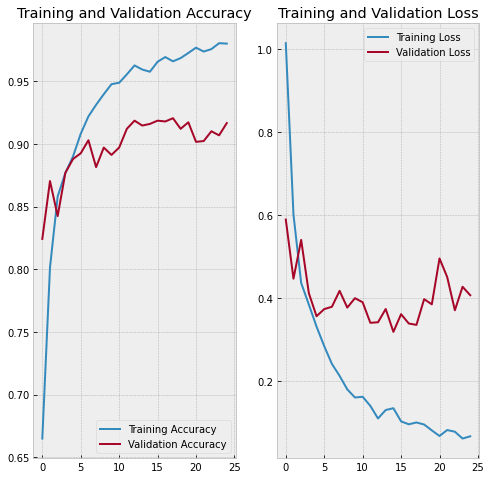

In [9]:
model = train_model (X, t)

In [10]:
#save the model
model.save('the_optimizers_classification_model.h5')

=========================================================================================================

### Testing the splitted Test Data Set

#### load the model

In [14]:
optimizer_classification_model = keras.models.load_model("the_optimizers_classification_model.h5")

#### Run the model on Test Data Set

In [17]:
#loading saved test data
X_test = np.load('X_test.npy')
t_test = np.load('t_test.npy')
print('Number of Samples: ', X.shape[0])

D=200
X_test_rs = preprocess_data (X_test, D)
print("\nReshaped Test Data: ", X_test_rs.shape)

score = model.evaluate(X_test_rs, t_test, verbose=0)
print('The Accuracy is: %.2f%%'%(score[1]*100))
print('The error is: %.2f%%'%(100-score[1]*100))


Number of Samples:  9032

Reshaped Test Data:  (1355, 200, 200, 3)
score [0.3701435923576355, 0.90848708152771]
The error is: 9.15%
The Accuracy is: 90.85%


In [36]:
#Prediction on Test Data
y_test = np.argmax(optimizer_model_load.predict(X_test_rs),axis=1)
print("\nPredicted Class: \n")
print(y_test)

print(classification_report(t_test, y_test, target_names=labels_names))


Predicted Class: 

[2 6 4 ... 2 0 2]
               precision    recall  f1-score   support

            x       0.92      0.90      0.91       135
  square root       0.93      0.93      0.93       134
    plus sign       0.86      0.97      0.91       134
negative sign       0.92      0.95      0.93       134
        equal       0.92      0.90      0.91       133
      percent       0.94      0.95      0.94       135
      partial       0.93      0.94      0.93       135
      product       0.86      0.86      0.86       134
           pi       0.87      0.75      0.81       133
    summation       0.96      0.96      0.96       135
      unknown       0.73      0.62      0.67        13

     accuracy                           0.91      1355
    macro avg       0.89      0.88      0.89      1355
 weighted avg       0.91      0.91      0.91      1355



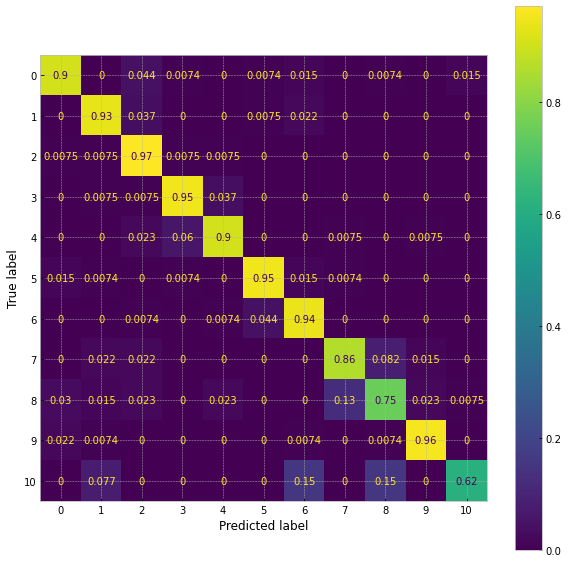

In [38]:
cm = confusion_matrix(t_test, y_test, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

=========================================================================================================